# Encoder-decoder architecture

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * Image captioning and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

In [1]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
import matplotlib.pyplot as plt
from vocab import Vocab
from sklearn.model_selection import train_test_split
import torch
from IPython.display import clear_output
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
from tqdm.notebook import tqdm
import copy
from tqdm import tqdm
from torch.nn import functional as F
from nltk.translate.bleu_score import corpus_bleu

# Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions.

* Data will be tokenized with WordPunctTokenizer.

* Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

* One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [2]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
# !wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [3]:
def tokenize(x):
    return ' '.join(nltk_tokenizer.tokenize(x.lower()))


nltk_tokenizer = WordPunctTokenizer()

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

## Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

## Let's take a look at some sample data

In [4]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

assert len(data_inp) == len(data_out), 'Number of inp & out sequences must be the same'

print('Number of sequences: %s' % len(data_inp), end='\n\n')

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=0.05,
                                                          random_state=0)
for i in range(3):
    print('Inp:', train_inp[i])
    print('Out:', train_out[i], end='\n\n')

Number of sequences: 50001

Inp: для гостей сервируется завтрак . кроме того , гости могут воспользоваться общей кухней .
Out: breakfast is provided and common kitchen facilities are featured .

Inp: в числе удобств всех номеров — мини - бар и телевизор со спутниковыми каналами , а в некоторых номерах есть гостиная зона и кондиционер .
Out: each comes with a minibar and satellite tv . some offer a seating area and air conditioning .

Inp: фитнес - центр гостиницы располагает 5 тренаж@@ ерами для фит@@ нес@@ а , а также мест@@ ами для игр и оборудованием для детей .
Out: the fitness centre of the hotel provides 5 types of fitness de@@ vi@@ ces and it offers games and special children - friendly equipment .



In [5]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [6]:
# Here's how you cast lines into ids and backwards
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print('Lines: %s' % batch_lines, end='\n\n')
print('Words to ids (0 = BOS, 1 = EOS):\n %s' % batch_ids, end='\n\n') # BOS = Begin Of Sentence
print('Back to words: %s' % batch_lines_restored)

Lines: ['имеется балкон .', 'гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

Words to ids (0 = BOS, 1 = EOS):
 tensor([[   0, 3487, 1870,   29,    1,    1,    1,    1],
        [   0, 2690, 2944, 1108,   29,    1,    1,    1],
        [   0, 2923, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6028, 2084,   29,    1,    1,    1,    1],
        [   0, 4928, 1870,   29,    1,    1,    1,    1]])

Back to words: ['имеется балкон .', 'гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


## Draw source and translation length distributions to estimate the scope of the task

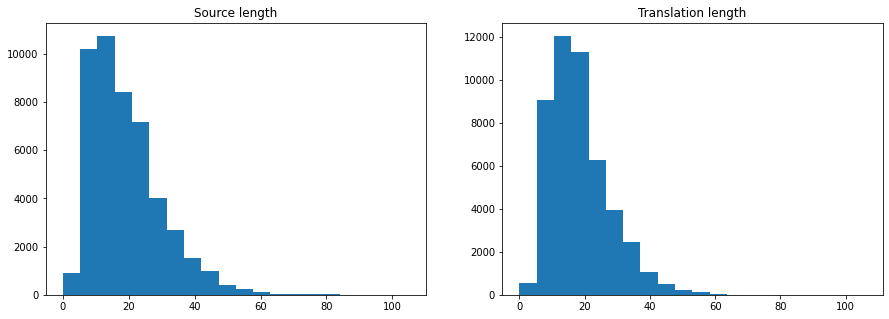

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("Translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

## Encoder-decoder model

The code below contains a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything

In [8]:
from my_models import BasicModel

In [9]:
assert torch.cuda.is_available()
device = 'cuda:4'

## Debugging area

In [10]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

dummy_translations, dummy_states = model.translate_lines(train_inp[:2], device, max_len=25)
translations = '\n'.join([line for line in dummy_translations])
print('Translations without training:\n%s' % translations)

Translations without training:
secluded metre unwind ce cleaning band@@ ord@@ parnas@@ cathe@@ uten@@ cricket art@@ @ @ taya 0 fus@@ kaliningrad to sanya prat @ @ taya 0
secluded metre unwind unwind ce seplein vo vo stainless ñas shan@@ soli@@ đ@@ memorial ordered memorial ordered zur showers cy@@ adi rurales brussels travelling express


## Training loss

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [11]:
from commons import compute_loss

In [12]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print('Loss: %s' % dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), 'Sorry for your loss'

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, 'Param %s received no gradients' % name

Loss: tensor(7.5465, device='cuda:4', grad_fn=<NegBackward>)


## Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [13]:
from commons import compute_bleu

In [14]:
compute_bleu(model, dev_inp, dev_out)

0.0019684483517276633

## Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [15]:
def train_model(model, n_iters=30000, batch_size=64, lr=1e-3, n_iters_break=700):
    metrics = {'train_loss': [], 'dev_bleu': [] }
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_weights = model.state_dict()
    best_bleu = -1
    best_step = -1
    with tqdm(range(n_iters)) as progress_bar:
        for i in progress_bar:
            step = len(metrics['train_loss']) + 1
            batch_ix = np.random.randint(len(train_inp), size=batch_size)
            batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
            batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

            opt.zero_grad()
            loss_t = compute_loss(model, batch_inp, batch_out)
            loss_t.backward()
            opt.step()

            metrics['train_loss'].append((step, loss_t.item()))
            if step % 100 == 0:
                bleu = compute_bleu(model, dev_inp, dev_out)
                metrics['dev_bleu'].append((step, bleu))

                if bleu > best_bleu:
                    best_bleu = bleu
                    best_step = step
                    best_weights = copy.deepcopy(model.state_dict())
                elif step - best_step >= n_iters_break:
                    break

                clear_output(wait=True)
                plt.figure(figsize=(12, 4))
                for i, (name, history) in enumerate(sorted(metrics.items())):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()

                print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
            
    model.load_state_dict(best_weights)
    return best_bleu

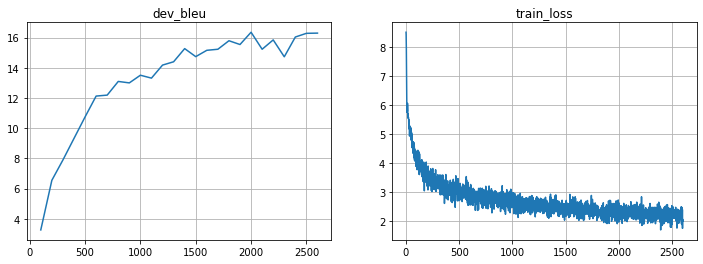

Mean loss=2.126


  9%|▉         | 2699/30000 [04:18<43:38, 10.43it/s]  

CPU times: user 31min 27s, sys: 6.87 s, total: 31min 34s
Wall time: 4min 18s


16.354050652058838

In [16]:
basic_model = BasicModel(inp_voc, out_voc).to(device)
%time train_model(basic_model, batch_size=64, lr=1e-3*5)

In [17]:
torch.save(basic_model.state_dict(), "basic_model")
basic_model.load_state_dict(torch.load("basic_model"))

<All keys matched successfully>

In [18]:
def beam_research(model, inp, out, model_name, beam_min=1, beam_max=10):
    """BLEU scores of a model with different beam_size"""
    
    beam_range = range(beam_min, beam_max + 1)
    blue_scores = []

    for beam_size in beam_range:
        blue = compute_bleu(model, inp, out, beam_size=beam_size)
        blue_scores.append(blue)

    plt.figure(figsize=(7, 5))
    plt.plot(beam_range, blue_scores)
    plt.title('Beam search results for %s' % model_name)
    plt.xticks(beam_range)
    plt.xlabel('beam size')
    plt.ylabel('blue score')
    plt.show()

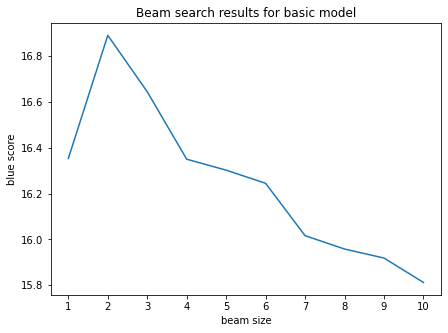

CPU times: user 39min 23s, sys: 5.8 s, total: 39min 29s
Wall time: 39min 27s


In [19]:
%time beam_research(basic_model, dev_inp, dev_out, 'basic model')

In [20]:
@torch.no_grad()
def translate_lines(model, inp, beam_size=None, bpe_sep='@@ '):
    for inp_line, trans_line in zip(inp, model.translate_lines(inp, device, beam_size=beam_size)[0]):
        print('Inp: %s' % inp_line.replace(bpe_sep, ''))
        print('Out: %s' % trans_line.replace(bpe_sep, ''))
        print()

In [21]:
translate_lines(basic_model, dev_inp[::700], 2)

Inp: в распоряжении гостей караоке .
Out: there is a shared kitchen at the property .

Inp: рядом со зданием предоставляется бесплатная общественная парковка .
Out: free public parking is available on site .

Inp: из отеля открывается вид на окружающие горы и пустыню .
Out: you can enjoy mountain views and mountain views .

Inp: гости отеля могут посещать хорошо оборудованный фитнес - центр .
Out: a fitness centre is available on site .



In [31]:
compute_bleu(basic_model, dev_inp, dev_out, beam_size=2)

16.889976731340216

## Simple Encoder-decoder model gets bleu 17.5, but quality of translation is so bad

# Model with attention

### Attention layer

Here we implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

## Seq2seq model with attention

We can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase. On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, we can add any tensor into the list of `encode` outputs. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are alternative ways to wire attention into network and different kinds of attention. For example [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [24]:
from my_models import AttentiveModel

### Training attentive model

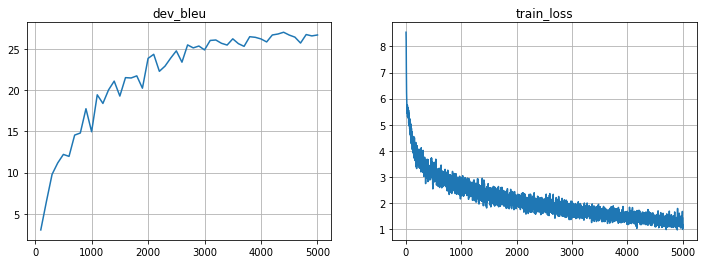

Mean loss=1.271


 17%|█▋        | 5099/30000 [17:33<1:25:44,  4.84it/s] 

CPU times: user 1h 6min 32s, sys: 18 s, total: 1h 6min 50s
Wall time: 17min 33s


26.990291157182035

In [25]:
attentive_model = AttentiveModel(inp_voc, out_voc, rnn_type='LSTM', bid=True).to(device)
%time train_model(attentive_model, lr=1e-3, batch_size=64)

In [26]:
torch.save(attentive_model.state_dict(), "att_model")
attentive_model.load_state_dict(torch.load("att_model"))

<All keys matched successfully>

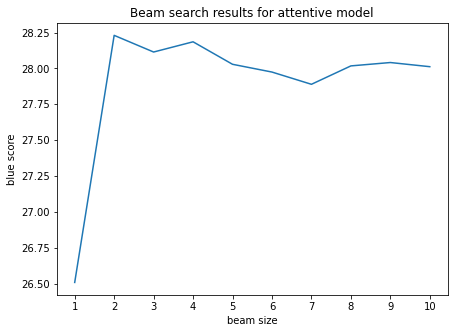

CPU times: user 39min 34s, sys: 4.78 s, total: 39min 39s
Wall time: 39min 37s


In [27]:
%time beam_research(attentive_model, dev_inp, dev_out, 'attentive model')

In [29]:
translate_lines(attentive_model, dev_inp[::700], 2)

Inp: в распоряжении гостей караоке .
Out: karaoke facilities are available .

Inp: рядом со зданием предоставляется бесплатная общественная парковка .
Out: free public parking is possible nearby .

Inp: из отеля открывается вид на окружающие горы и пустыню .
Out: the hotel overlooks the surrounding mountains and mountains .

Inp: гости отеля могут посещать хорошо оборудованный фитнес - центр .
Out: guests can enjoy a fitness centre .



In [30]:
compute_bleu(attentive_model, dev_inp, dev_out, beam_size=2)

28.230211721471022

## Attentive model gets bleu 28.2, it is significantly better then simple model and translation so better

# Let's improve out model using Reinforcement Learning

## Self-critical policy gradient

In this section we'll implement algorithm called self-critical sequence training (here's an [article](https://arxiv.org/abs/1612.00563)).

The algorithm is a vanilla [policy gradient](https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d) with a special baseline.

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$

Here reward R(x,y) is a __BLEU score__. The baseline __b(x)__ represents how well model fares on sentence __x__.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/scheme.png)

In [32]:
def get_bleu(ref, trans):
    smooth = lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
    return corpus_bleu(
        [[ref.split()]], 
        [trans.split()], 
        smoothing_function=smooth
    ) * 100


def compute_reward(translations, actual, bpe_sep='@@ '):
    translations = out_voc.to_lines(translations)
    actual = out_voc.to_lines(actual)
    
    translations = [x.replace(bpe_sep, '') for x in translations]
    actual = [x.replace(bpe_sep, '') for x in actual]
    
    rewards = [get_bleu(ref, trans) for ref, trans in zip(actual, translations)]
    
    return torch.tensor(rewards)


def scst_translate(model, batch_inp, max_len, greedy=False, eps=1e-30):
    batch_size = batch_inp.shape[0]
    
    state = model.encode(batch_inp)
    outputs = [torch.full([batch_size], out_voc.bos_ix, dtype=torch.int64, device=device)]
    logits_seq = [torch.log(F.one_hot(outputs[0], len(out_voc)) + eps)]
            
    for i in range(max_len):
        state, logits = model.decode_step(state, outputs[-1])
        logits_seq.append(logits)
        if greedy:
            outputs.append(logits.argmax(dim=-1))
        else:
            probs = F.softmax(logits, dim=-1)
            outputs.append(torch.multinomial(probs, 1)[:, 0])
            
    return torch.stack(outputs, 1), F.log_softmax(torch.stack(logits_seq, 1), dim=-1)


def scst_objective_on_batch(model, batch_size=32, max_len=100, entropy_coef=0.01):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    sample_translations, sample_logp = scst_translate(model, batch_inp, max_len, greedy=False)
    
    assert tuple(sample_translations.shape) == (batch_size, max_len + 1)
    assert tuple(sample_logp.shape) == (batch_size, max_len + 1, len(out_voc))
    
    greedy_translations, greedy_logp = scst_translate(model, batch_inp, max_len, greedy=True)
   
    # compute rewards and advantage
    rewards = compute_reward(sample_translations, batch_out).to(device)
    baseline = compute_reward(greedy_translations, batch_out).to(device)
    
    assert tuple(rewards.shape) == (batch_size,)
    
    advantage = rewards - baseline

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(sample_logp *
                  F.one_hot(sample_translations, len(out_voc)), dim=-1)
    
    assert tuple(logp_sample.shape) == (batch_size, max_len + 1)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:, None]

    assert tuple(J.shape) == (batch_size, max_len + 1)

    # average with mask
    mask = out_voc.compute_mask(sample_translations)
    loss = -torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy
    entropy = -torch.sum(sample_logp.exp() * sample_logp, dim=-1)

    assert tuple(entropy.shape) == (batch_size, max_len + 1)

    reg = -entropy_coef * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

## Policy gradient training


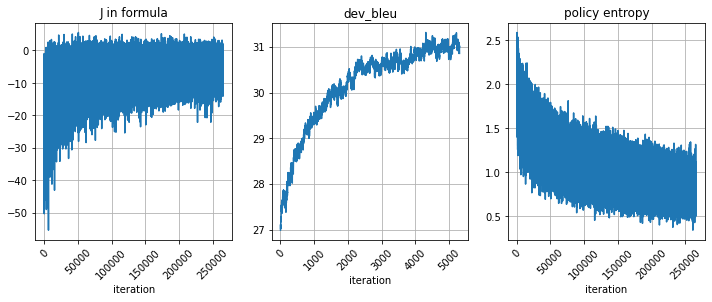

In [50]:
loss_history, entropy_history, bleu_history = [], [], []
opt = torch.optim.Adam(attentive_model.parameters(), lr=1e-5)

best_weights = attentive_model.state_dict()
best_bleu = -1
best_step = -1

for i in tqdm(range(300 * 1000)):
    loss, ent = scst_objective_on_batch(attentive_model)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    loss_history.append(loss.item())
    entropy_history.append(ent.item())

    if (i + 1) % 50 == 0:
        bleu = compute_bleu(attentive_model, dev_inp, dev_out)
        bleu_history.append(bleu)
        
        if bleu > best_bleu:
            best_bleu = bleu
            best_step = i
            best_weights = copy.deepcopy(attentive_model.state_dict())
        elif i - best_step >= 50 * 1000:
            break

        clear_output(wait=True)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.xticks(rotation=45)
        plt.xlabel('iteration')
        plt.title('J in formula')

        plt.subplot(1, 3, 2)
        plt.plot(bleu_history)
        plt.grid()
        plt.xticks(rotation=45)
        plt.xlabel('iteration')
        plt.title('dev_bleu')

        plt.subplot(1, 3, 3)
        plt.plot(entropy_history)
        plt.grid()
        plt.xticks(rotation=45)
        plt.xlabel('iteration')
        plt.title('policy entropy')

        plt.show()
        
attentive_model.load_state_dict(best_weights)

In [53]:
torch.save(attentive_model.state_dict(), "att_model_rl")
attentive_model.load_state_dict(torch.load("att_model_rl"))

<All keys matched successfully>

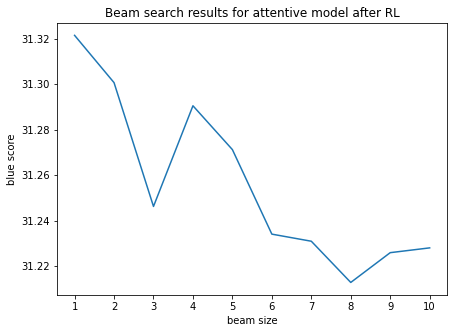

CPU times: user 51min 35s, sys: 11.9 s, total: 51min 47s
Wall time: 51min 45s


In [54]:
%time beam_research(attentive_model, dev_inp, dev_out, 'attentive model after RL')

In [56]:
translate_lines(attentive_model, dev_inp[::700], 1)

Inp: в распоряжении гостей караоке .
Out: there is also a karaoke .

Inp: рядом со зданием предоставляется бесплатная общественная парковка .
Out: free public parking is available nearby .

Inp: из отеля открывается вид на окружающие горы и пустыню .
Out: the hotel offers views of the surrounding mountains and the desert .

Inp: гости отеля могут посещать хорошо оборудованный фитнес - центр .
Out: guests can enjoy a well - equipped fitness centre .



In [57]:
compute_bleu(attentive_model, dev_inp, dev_out, beam_size=1)

31.321521579930828

In [58]:
def print_num_model_parameters(model):
    res = 0
    for x in model.parameters():
        res += x.reshape(-1).shape[0]
    print('%.1f M parameters' % (res / 10**6))

In [59]:
print_num_model_parameters(attentive_model)

8.2 M parameters


## After RL our model get's BLEU 31.3, nice improvement

# Transformers

Now we look at Facebook model at Workshop Machine Translation 2019

They submissions are ranked first in all four directions of the human evaluation campaign

In [60]:
mname = "facebook/wmt19-ru-en"
tokenizer = FSMTTokenizer.from_pretrained(mname)
device_2 = 'cuda:3'
model = FSMTForConditionalGeneration.from_pretrained(mname).to(device_2)

In [61]:
print_num_model_parameters(model)

293.2 M parameters


## Let's find out how it actually should be executed

In [63]:
inp = "я тестирую модель и сейчас мы посмотрим как она работает"
input_ids = tokenizer.encode(inp, return_tensors="pt").to(device_2)
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(tokenize(decoded))

i am testing the model and now we will see how it works


# Compute BLEU at development set & see translations

In [65]:
def compute_blue_transformer(model, inp_lines, out_lines, bpe_sep='@@ '):
    inp = [line.replace(bpe_sep, '') for line in inp_lines]
    out = [line.replace(bpe_sep, '') for line in out_lines]
    translations = []
    for src in tqdm(inp):
        input_ids = tokenizer.encode(src, return_tensors="pt").to(device_2)
        outputs = model.generate(input_ids, num_beams=2)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        decoded = tokenize(decoded)
        translations.append(decoded)
        
    return corpus_bleu(
        [[ref.split()] for ref in out],
        [trans.split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
    ) * 100

for inp_line in dev_inp[::700]:
    inp = inp_line.replace('@@ ', '')
    input_ids = tokenizer.encode(inp, return_tensors="pt").to(device_2)
    outputs = model.generate(input_ids)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    decoded = tokenize(decoded)
    print(inp)
    print(decoded)
    print()

в распоряжении гостей караоке .
karaoke is at guests " disposal .

рядом со зданием предоставляется бесплатная общественная парковка .
free public parking is available next to the building .

из отеля открывается вид на окружающие горы и пустыню .
the hotel overlooks the surrounding mountains and desert .

гости отеля могут посещать хорошо оборудованный фитнес - центр .
guests can use the hotel ' s well - equipped fitness centre .



In [66]:
compute_blue_transformer(model, dev_inp, dev_out)

100%|██████████| 2501/2501 [22:47<00:00,  1.83it/s]


33.73126594795731

# Looks good, BLEU is 33.7

Of course, results will be slightly better if we finetune this model at our dataset, but it really hard:

* They use different tokenizer with bigger number of BPE tokens

* We'll must be very carefully, it's very easy to overfit on the train dataset

* Transformer model has x36 more parameters and similar architecture. Finetuning this model may take about 30 hours. In we run 20 experiments it will take about 600 hours = 1 month. This is fine, considering that it's time required only to train model